# Análise Exploratória - Dados Atualizados

Este notebook contém a análise exploratória dos dados atualizados com as variáveis `volume`, `inv` e `users`.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import ccf

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10


In [22]:
# Carregando os dados
data = pd.read_csv('data_updated.csv')
data['week'] = pd.to_datetime(data['week'])
data = data.set_index('week')

print(f"Período dos dados: {data.index.min()} até {data.index.max()}")
print(f"Total de observações: {len(data)}")
# print(f"\nPrimeiras linhas:")
#data.head(10)


Período dos dados: 2022-10-31 00:00:00 até 2025-10-27 00:00:00
Total de observações: 157


## 1. Análise Univariada das Novas Variáveis


### 1.1 Estatísticas Descritivas


In [23]:
# Estatísticas descritivas completas
# print("=" * 80)
# print("ESTATÍSTICAS DESCRITIVAS")
# print("=" * 80)
# print("\n")

# for col in ['volume', 'inv', 'users']:
#     print(f"\n{'='*50}")
#     print(f"  {col.upper()}")
#     print(f"{'='*50}")

#     desc = data[col].describe()

#     print(f"Contagem:        {desc['count']:.0f}")
#     print(f"Média:           {desc['mean']:.4f}")
#     print(f"Mediana:         {data[col].median():.4f}")
#     print(f"Desvio Padrão:   {desc['std']:.4f}")
#     print(f"Variância:       {data[col].var():.4f}")
#     print(f"\nMínimo:          {desc['min']:.4f}")
#     print(f"Q1 (25%):        {desc['25%']:.4f}")
#     print(f"Q2 (50%):        {desc['50%']:.4f}")
#     print(f"Q3 (75%):        {desc['75%']:.4f}")
#     print(f"Máximo:          {desc['max']:.4f}")
#     print(f"\nAmplitude:       {desc['max'] - desc['min']:.4f}")
#     print(f"IQR:             {desc['75%'] - desc['25%']:.4f}")
#     print(f"CV:              {(desc['std']/desc['mean'])*100:.2f}%")
#     print(f"Assimetria:      {data[col].skew():.4f}")
#     print(f"Curtose:         {data[col].kurtosis():.4f}")

# print("\n" + "="*80)


In [24]:
# Tabela resumida
summary_df = data.describe().T
summary_df['median'] = data.median()
summary_df['cv'] = (summary_df['std'] / summary_df['mean']) * 100
summary_df['skewness'] = data.skew()
summary_df['kurtosis'] = data.kurtosis()

print("\nTabela Resumida:")
summary_df[['mean', 'median', 'std', 'min', 'max', 'cv', 'skewness', 'kurtosis']].round(4)



Tabela Resumida:


,mean,median,std,min,max,cv,skewness,kurtosis
volume,4.8204,3.2500,5.1623,0.1400,24.5200,107.0933,1.4754,2.0278
inv,0.7130,0.4649,0.8892,0.0002,5.6239,124.7212,2.3668,7.2621
users,6.5768,3.8470,6.5968,0.4010,29.3320,100.3039,1.3360,1.3107


### 1.2 Visualização Temporal das Séries


/tmp/ipykernel_97263/2140445128.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


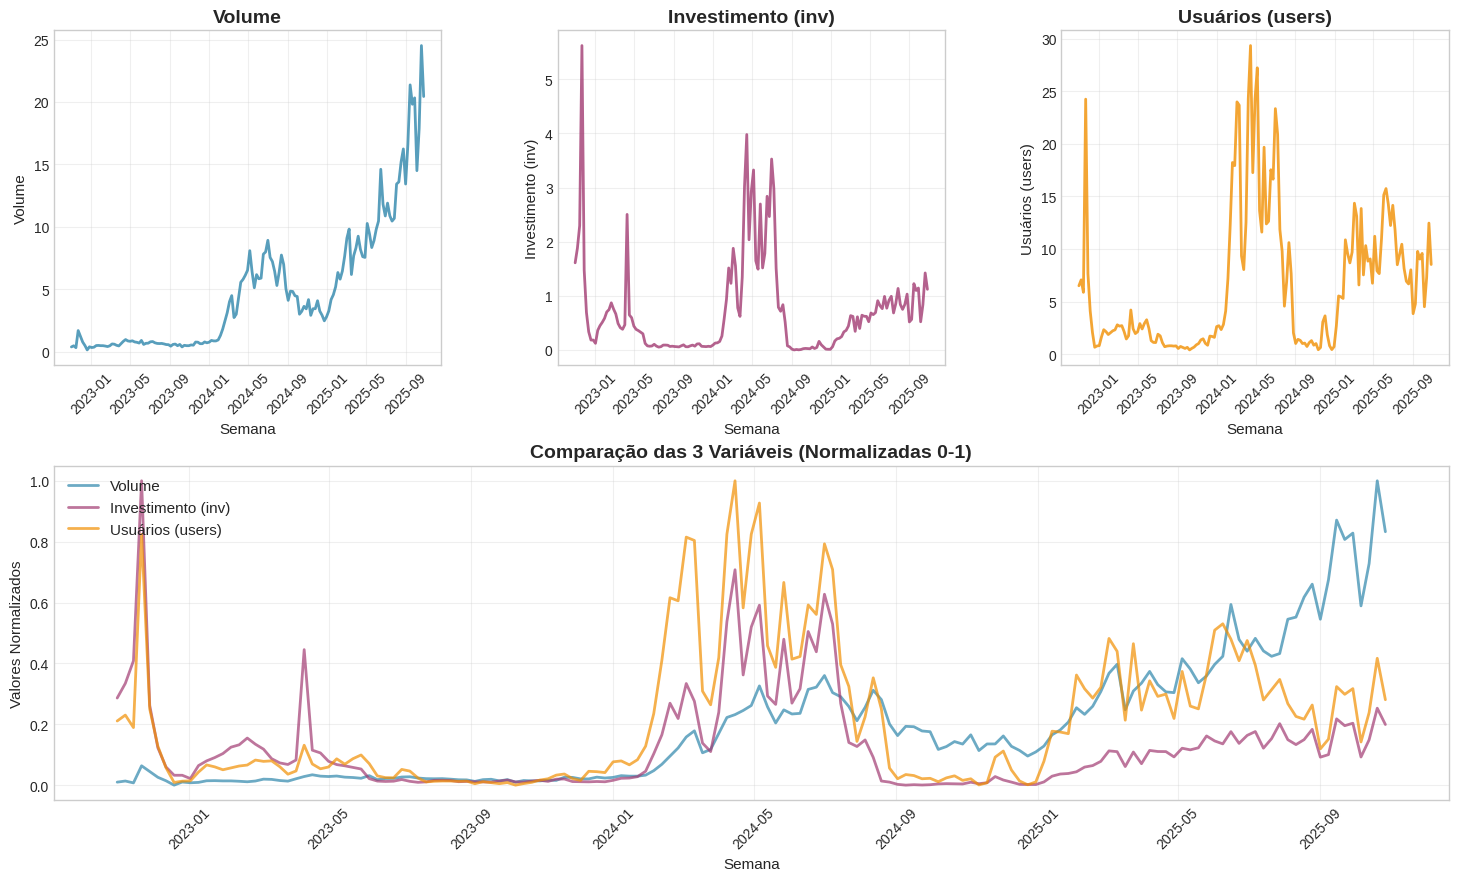

In [25]:
# Figura com 3 gráficos em cima e 1 embaixo
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Cores para cada variável
colors = {'volume': '#2E86AB', 'inv': '#A23B72', 'users': '#F18F01'}

# Gráficos individuais em cima (3 colunas)
variables = ['volume', 'inv', 'users']
titles = ['Volume', 'Investimento (inv)', 'Usuários (users)']

for i, (var, title) in enumerate(zip(variables, titles)):
    ax = fig.add_subplot(gs[0, i])
    ax.plot(data.index, data[var], color=colors[var], linewidth=2, alpha=0.8)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Semana', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# Gráfico combinado embaixo (ocupando as 3 colunas)m
ax_combined = fig.add_subplot(gs[1, :])

# Normalizar os dados para plotar juntos (escala 0-1)
data_normalized = (data - data.min()) / (data.max() - data.min())

for var, title in zip(variables, titles):
    ax_combined.plot(data.index, data_normalized[var],
                     label=title, color=colors[var], linewidth=2, alpha=0.7)

ax_combined.set_title('Comparação das 3 Variáveis (Normalizadas 0-1)',
                      fontsize=14, fontweight='bold')
ax_combined.set_xlabel('Semana', fontsize=11)
ax_combined.set_ylabel('Valores Normalizados', fontsize=11)
ax_combined.legend(loc='upper left', fontsize=11)
ax_combined.grid(True, alpha=0.3)
ax_combined.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**\*Os valores estão normalizados no gráfico em conjunto**

Parace haver uma relação forte entre 'users' e 'inv'. Ambos seguem um mesmo padrão, principalmente nos picos ocorridos em 2022 e na metade de 2023. O volume corresponde de forma mais suave, isso quando corresponde. Além disso, ao final vemos uma força de cresciemnto muito maior no volume do que nas outras variáveis.

### 1.3 Distribuição dos Valores (Histogramas + Boxplots)


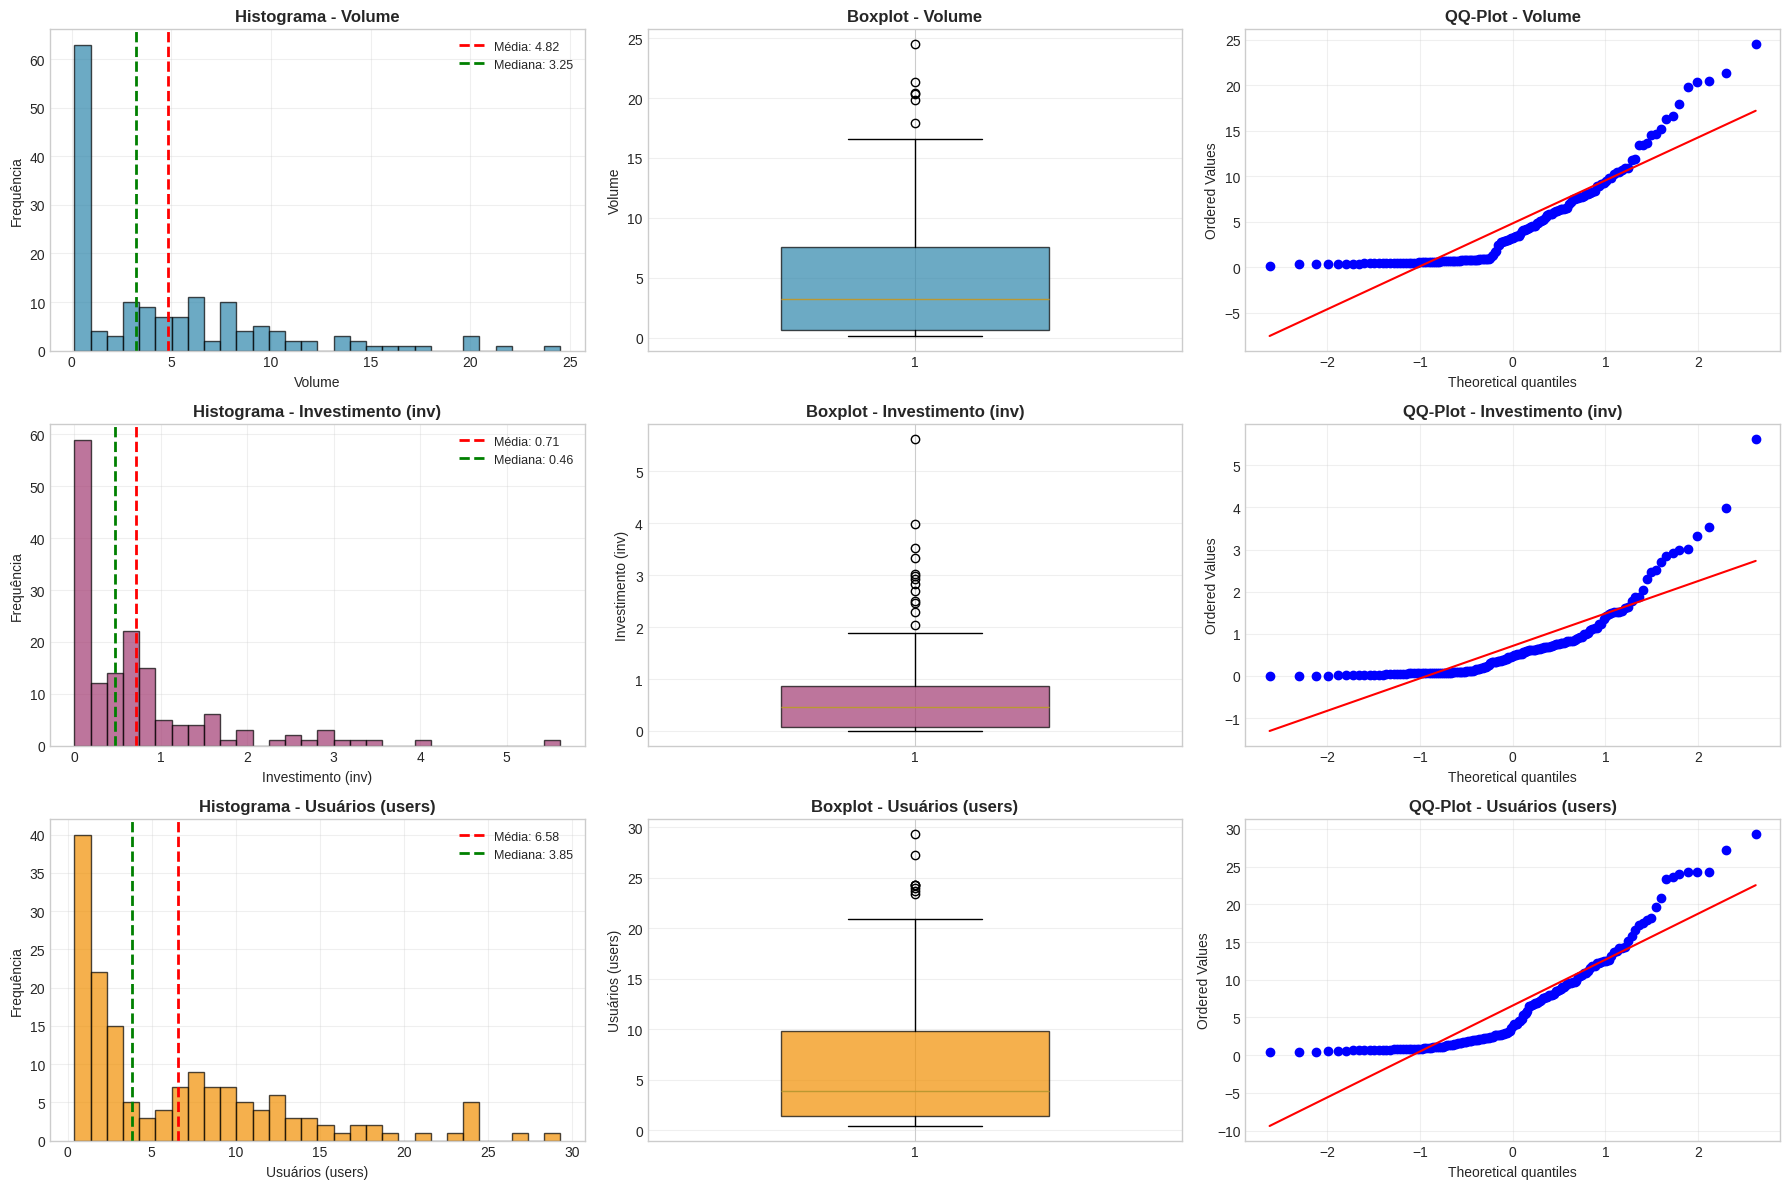

In [26]:
# Figura com histogramas e boxplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, (var, title) in enumerate(zip(variables, titles)):
    # Histograma
    ax_hist = axes[i, 0]
    ax_hist.hist(data[var], bins=30, color=colors[var], alpha=0.7, edgecolor='black')
    ax_hist.axvline(data[var].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {data[var].mean():.2f}')
    ax_hist.axvline(data[var].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {data[var].median():.2f}')
    ax_hist.set_title(f'Histograma - {title}', fontsize=12, fontweight='bold')
    ax_hist.set_xlabel(title, fontsize=10)
    ax_hist.set_ylabel('Frequência', fontsize=10)
    ax_hist.legend(fontsize=9)
    ax_hist.grid(True, alpha=0.3)

    # Boxplot
    ax_box = axes[i, 1]
    bp = ax_box.boxplot(data[var], vert=True, patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor(colors[var])
    bp['boxes'][0].set_alpha(0.7)
    ax_box.set_title(f'Boxplot - {title}', fontsize=12, fontweight='bold')
    ax_box.set_ylabel(title, fontsize=10)
    ax_box.grid(True, alpha=0.3, axis='y')

    # QQ-Plot (Normalidade)
    ax_qq = axes[i, 2]
    stats.probplot(data[var], dist="norm", plot=ax_qq)
    ax_qq.set_title(f'QQ-Plot - {title}', fontsize=12, fontweight='bold')
    ax_qq.grid(True, alpha=0.3)

    # Calcular outliers
    Q1 = data[var].quantile(0.25)
    Q3 = data[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

plt.tight_layout()
plt.show()


## 2. Análise de Correlação e Relações


### 2.1 Matriz de Correlação


In [42]:
# Matriz de correlação
corr_matrix = data[['volume', 'inv', 'users']].corr()

# Correlação de Spearman (não paramétrica)
corr_spearman = data[['volume', 'inv', 'users']].corr(method='spearman')

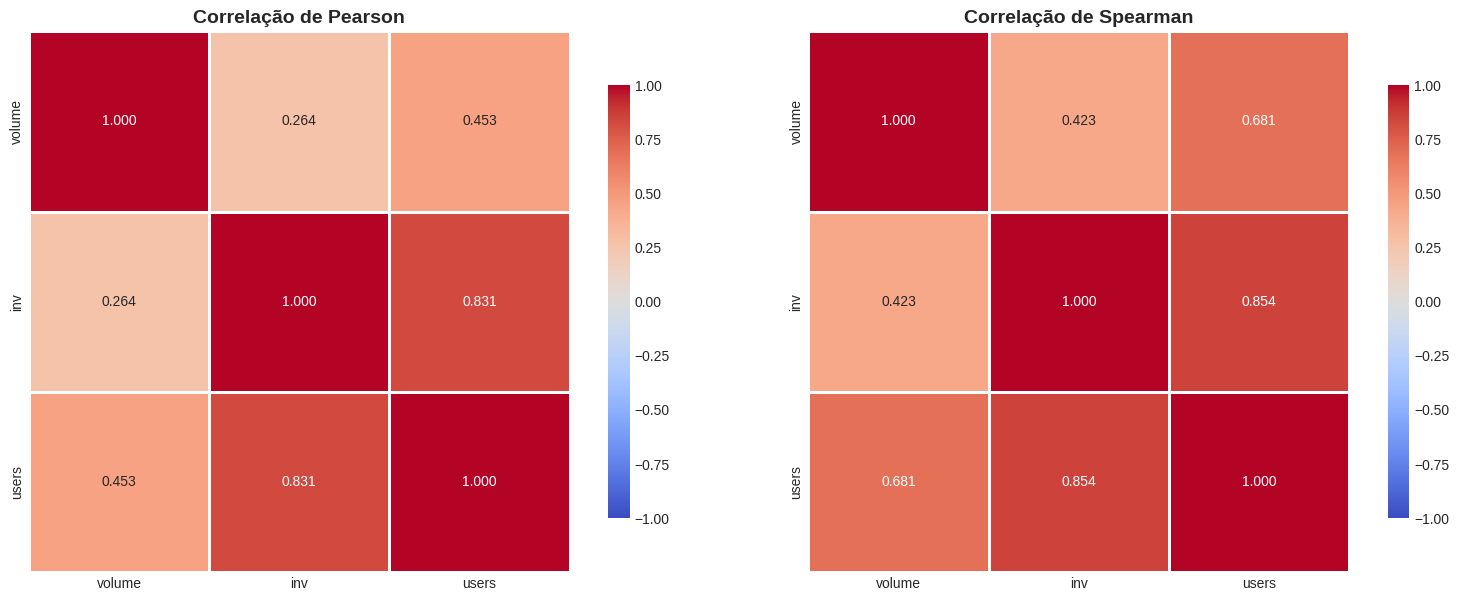

In [28]:
# Visualização da matriz de correlação
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=2, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Correlação de Pearson', fontsize=14, fontweight='bold')

# Spearman
sns.heatmap(corr_spearman, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=2, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Correlação de Spearman', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 2.2 Scatter Plots entre Variáveis


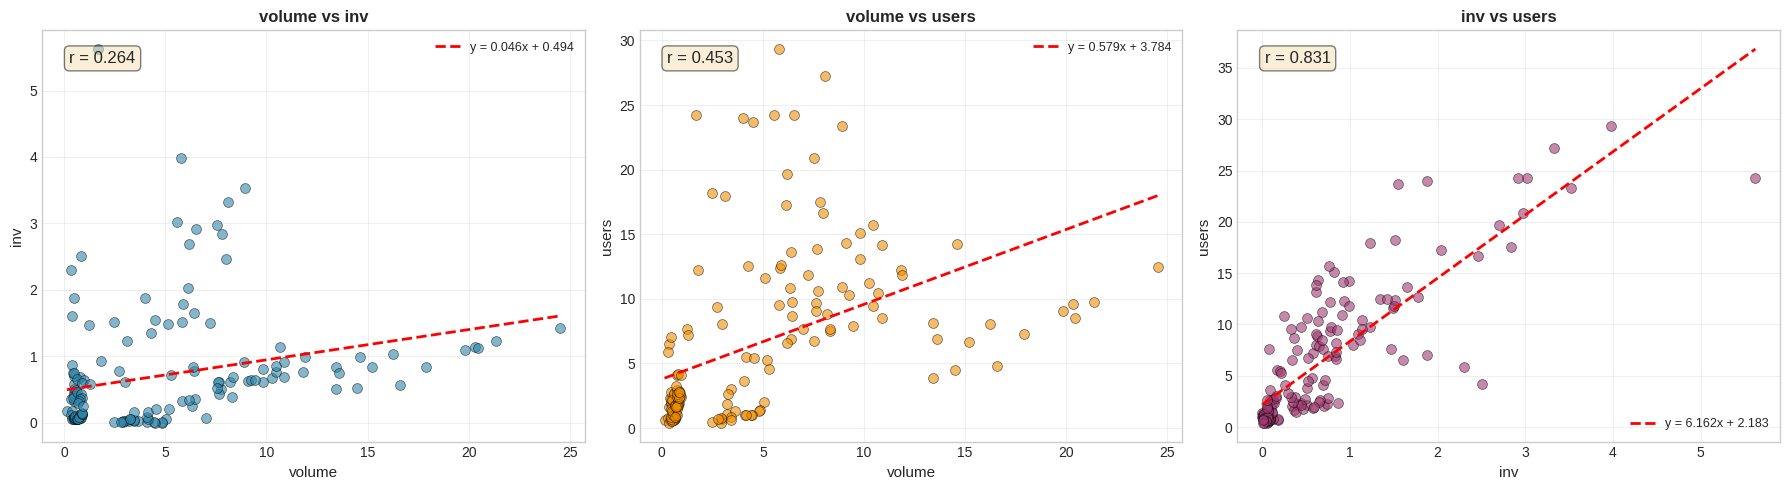

In [29]:
# Scatter plots com linha de tendência
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [('volume', 'inv'), ('volume', 'users'), ('inv', 'users')]
pair_colors = ['#2E86AB', '#F18F01', '#A23B72']

for ax, (var1, var2), color in zip(axes, pairs, pair_colors):
    # Scatter
    ax.scatter(data[var1], data[var2], alpha=0.6, s=50, color=color, edgecolors='black', linewidth=0.5)

    # Linha de tendência
    z = np.polyfit(data[var1], data[var2], 1)
    p = np.poly1d(z)
    ax.plot(data[var1].sort_values(), p(data[var1].sort_values()),
            "r--", linewidth=2, label=f'y = {z[0]:.3f}x + {z[1]:.3f}')

    # Correlação
    corr = data[var1].corr(data[var2])
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_xlabel(var1, fontsize=11)
    ax.set_ylabel(var2, fontsize=11)
    ax.set_title(f'{var1} vs {var2}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Aqui, vamos olhar por partes. 

No primeiro gráfico (mais a esquerda), podemos ver que há dois padroes, para volumes abaixo de 10 e outro para volumes acima de 10. Acima de 10, parece haver uma correlação maior, enquanto abaixo parace não haver.

No segundo gráfico, algo parecido pode ser observaod, mas com menos intensidade.

Já no terceiro, a correlação é muito mais clara em todo dominio.

### 2.3 Análise de Correlação Anualizada (2023, 2024, 2025)


In [ ]:
# Separar dados por ano
data_copy = data.copy()
data_copy['year'] = data_copy.index.year

# Filtrar por ano
data_2023 = data_copy[data_copy['year'] == 2023]
data_2024 = data_copy[data_copy['year'] == 2024]
data_2025 = data_copy[data_copy['year'] == 2025]

# Calcular correlações por ano
correlations_by_year = {}

for year, year_data in [('2023', data_2023), ('2024', data_2024), ('2025', data_2025)]:
    if len(year_data) > 0:
        corr_pearson = year_data[['volume', 'inv', 'users']].corr()
        corr_spearman = year_data[['volume', 'inv', 'users']].corr(method='spearman')
        correlations_by_year[year] = {
            'pearson': corr_pearson,
            'spearman': corr_spearman,
            'n_obs': len(year_data)
        }

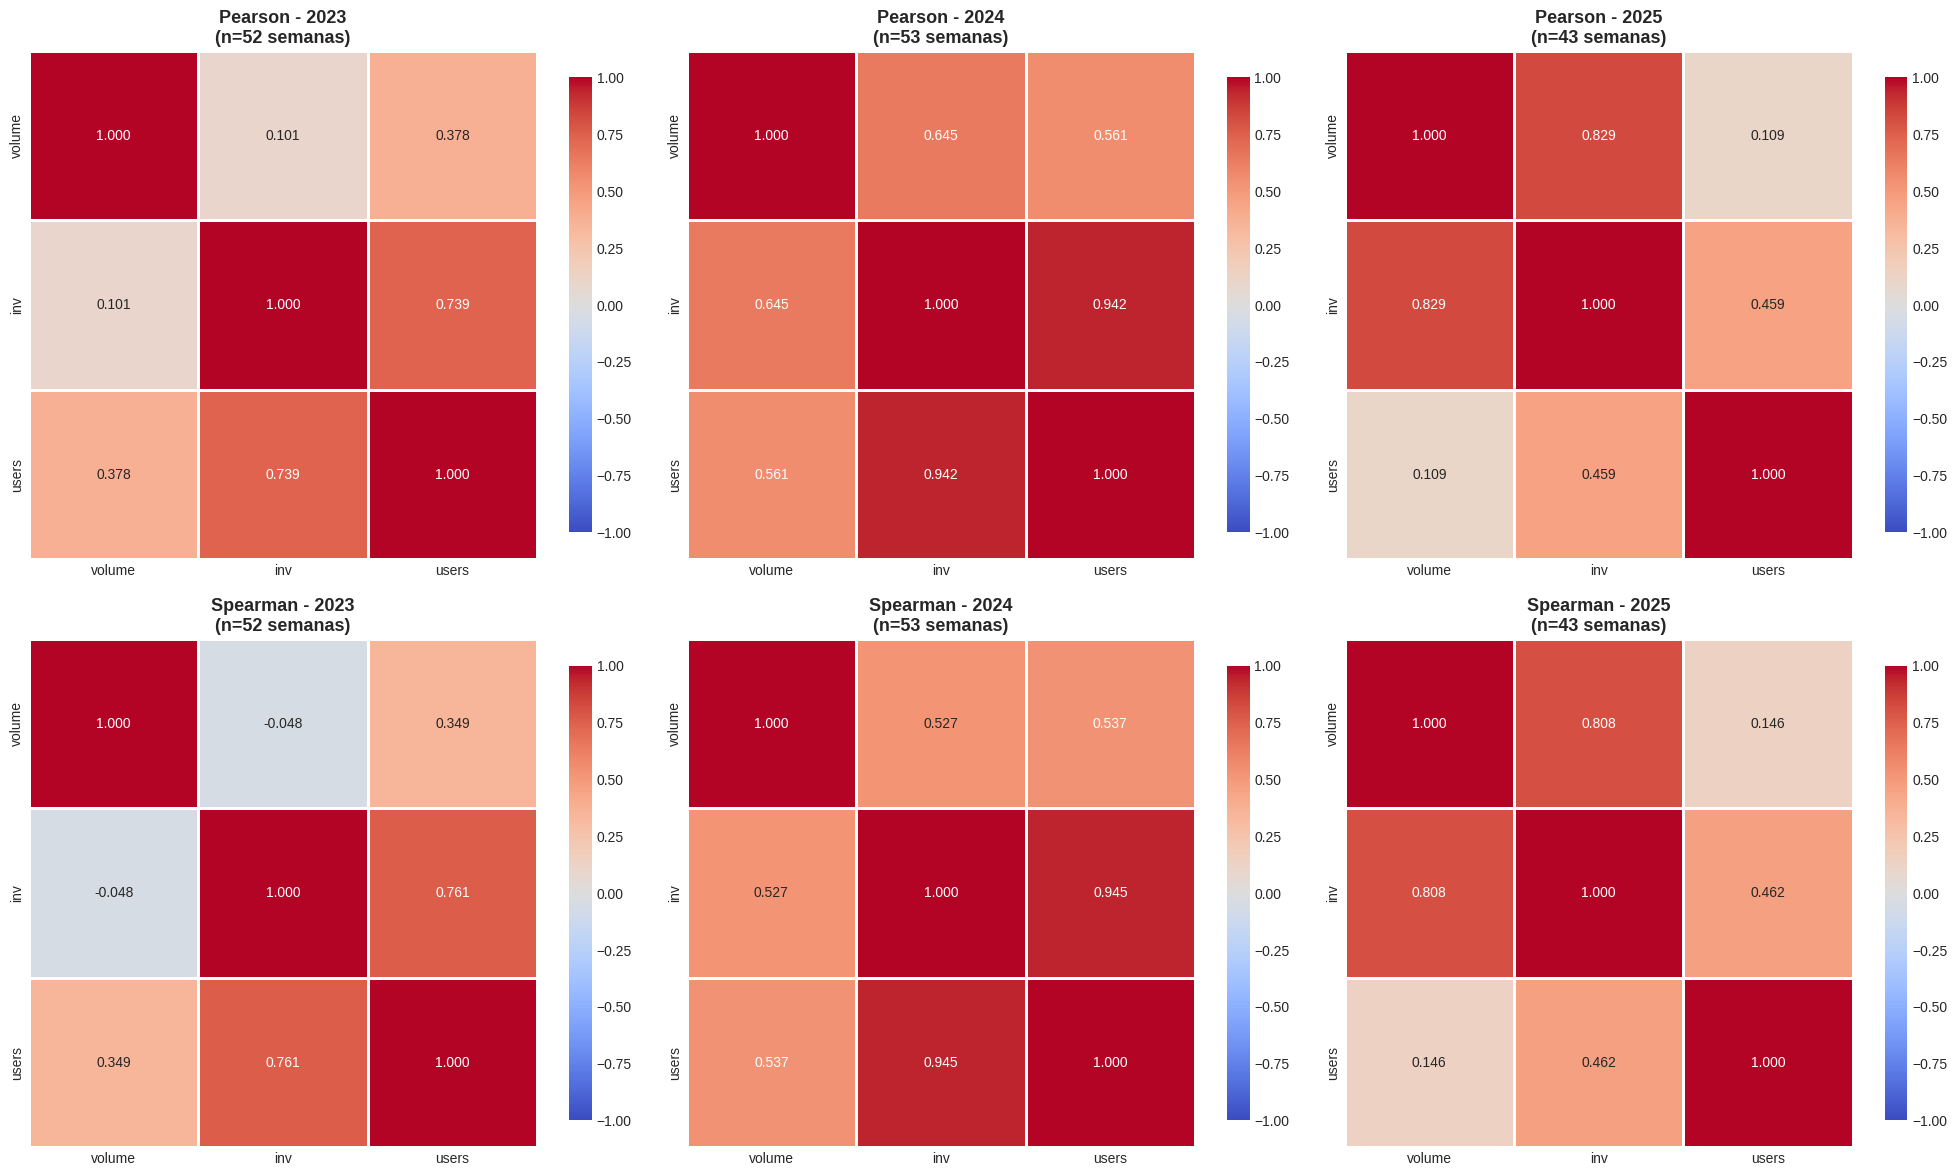

In [48]:
# Visualização: Heatmaps de correlação por ano
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

years = ['2023', '2024', '2025']

# Pearson (linha superior)
for i, year in enumerate(years):
    corr_matrix = correlations_by_year[year]['pearson']
    n_obs = correlations_by_year[year]['n_obs']

    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
                center=0, vmin=-1, vmax=1, square=True,
                linewidths=2, cbar_kws={"shrink": 0.8}, ax=axes[0, i])
    axes[0, i].set_title(f'Pearson - {year}\n(n={n_obs} semanas)', fontsize=13, fontweight='bold')

# Spearman (linha inferior)
for i, year in enumerate(years):
    corr_matrix = correlations_by_year[year]['spearman']
    n_obs = correlations_by_year[year]['n_obs']

    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
                center=0, vmin=-1, vmax=1, square=True,
                linewidths=2, cbar_kws={"shrink": 0.8}, ax=axes[1, i])
    axes[1, i].set_title(f'Spearman - {year}\n(n={n_obs} semanas)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


Aqui, podemos ver um mudança nos padroes de correlação ao longo dos anos.

'inv' e 'users' apresentam uma correlação alta nos primeiros dois anos (2023 e 2024), mas essa correlação fica mais fraca em 2024, no qual a correlação entre 'volume' e 'inv' passa a ser mais evidente.

Falando um pouco mais sobre o 'volume', fica claro que há um aumenta da correlação entre o 'volume' e 'inv' com o passar dos anos.

'volume' e 'users' não parecem ter uma relação significativa. Apenas em 2024, quando 'user' está muito correlacionado com 'inv'.

#### 2.3.1 Tendência das correlações ao longo dos anos

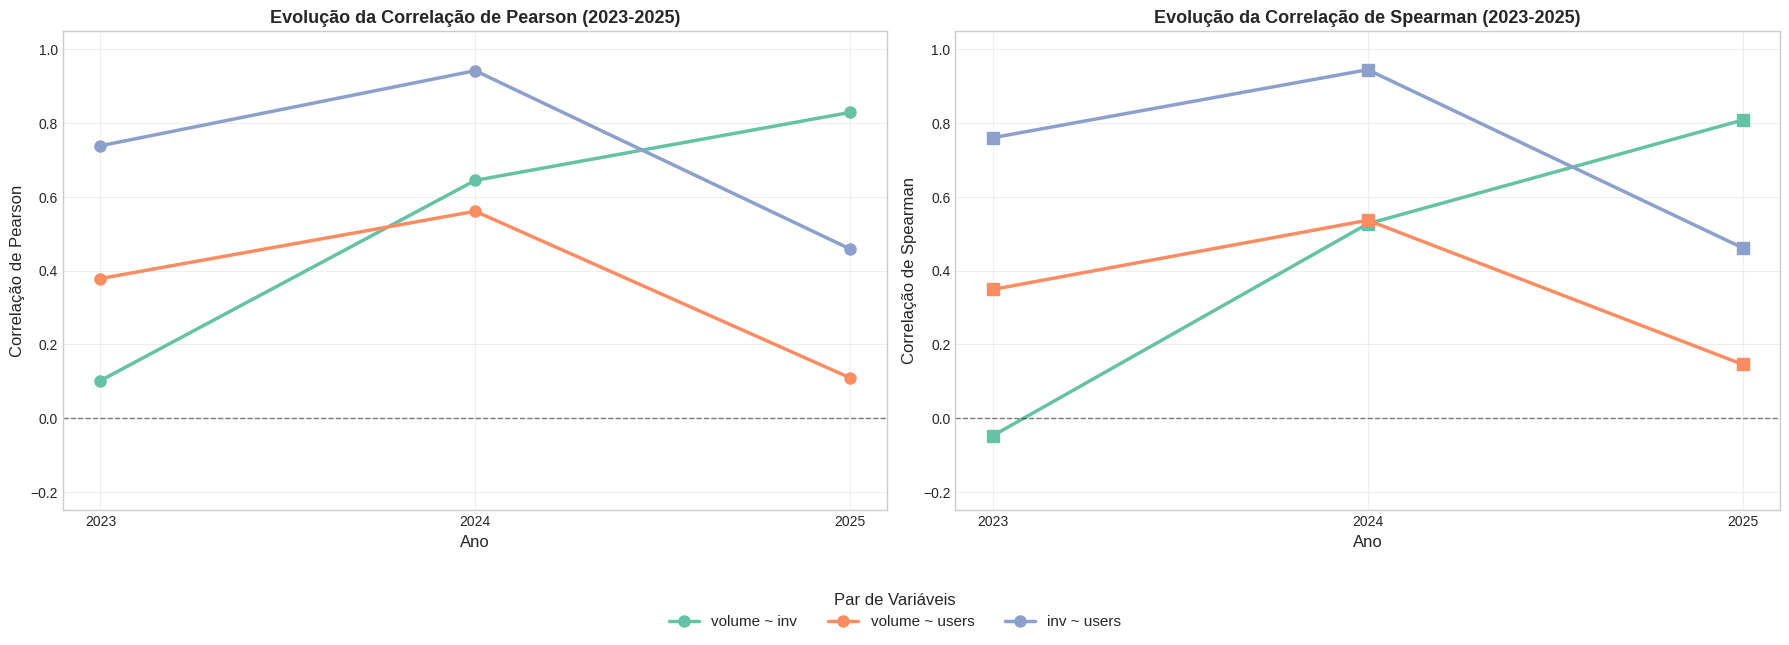

In [60]:
# Define os pares de variáveis a comparar
columns = list(next(iter(correlations_by_year.values()))['pearson'].columns)
pair_names = []
pairs_idx = []
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        pair_names.append(f"{columns[i]} ~ {columns[j]}")
        pairs_idx.append((i, j))
years = list(correlations_by_year.keys())

# Gera as listas de correlações diretamente a partir das matrizes de correlação
pearson_data = {pair: [] for pair in pair_names}
spearman_data = {pair: [] for pair in pair_names}

for year in years:
    corr_pearson = correlations_by_year[year]['pearson']
    corr_spearman = correlations_by_year[year]['spearman']
    for pair, (i, j) in zip(pair_names, pairs_idx):
        pearson_data[pair].append(corr_pearson.iloc[i, j])
        spearman_data[pair].append(corr_spearman.iloc[i, j])

# Paleta de cores para cada par
import seaborn as sns
colors = sns.color_palette("Set2", len(pair_names))
pair_colors = dict(zip(pair_names, colors))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Pearson
for pair in pair_names:
    axes[0].plot(years, pearson_data[pair], marker='o', markersize=8, linewidth=2.5,
                 label=pair, color=pair_colors[pair])
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Ano', fontsize=12)
axes[0].set_ylabel('Correlação de Pearson', fontsize=12)
axes[0].set_title('Evolução da Correlação de Pearson (2023-2025)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.25, 1.05)
axes[0].set_xticks(years)

# Gráfico 2: Spearman
for pair in pair_names:
    axes[1].plot(years, spearman_data[pair], marker='s', markersize=8, linewidth=2.5,
                 label=pair, color=pair_colors[pair])
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Ano', fontsize=12)
axes[1].set_ylabel('Correlação de Spearman', fontsize=12)
axes[1].set_title('Evolução da Correlação de Spearman (2023-2025)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.25, 1.05)
axes[1].set_xticks(years)

# legenda
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Par de Variáveis", fontsize=11, title_fontsize=12,
           loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=len(pair_names), frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Deixa espaço para a legenda embaixo
plt.show()


#### 2.3.2 Scatter Plots entre Variáveis


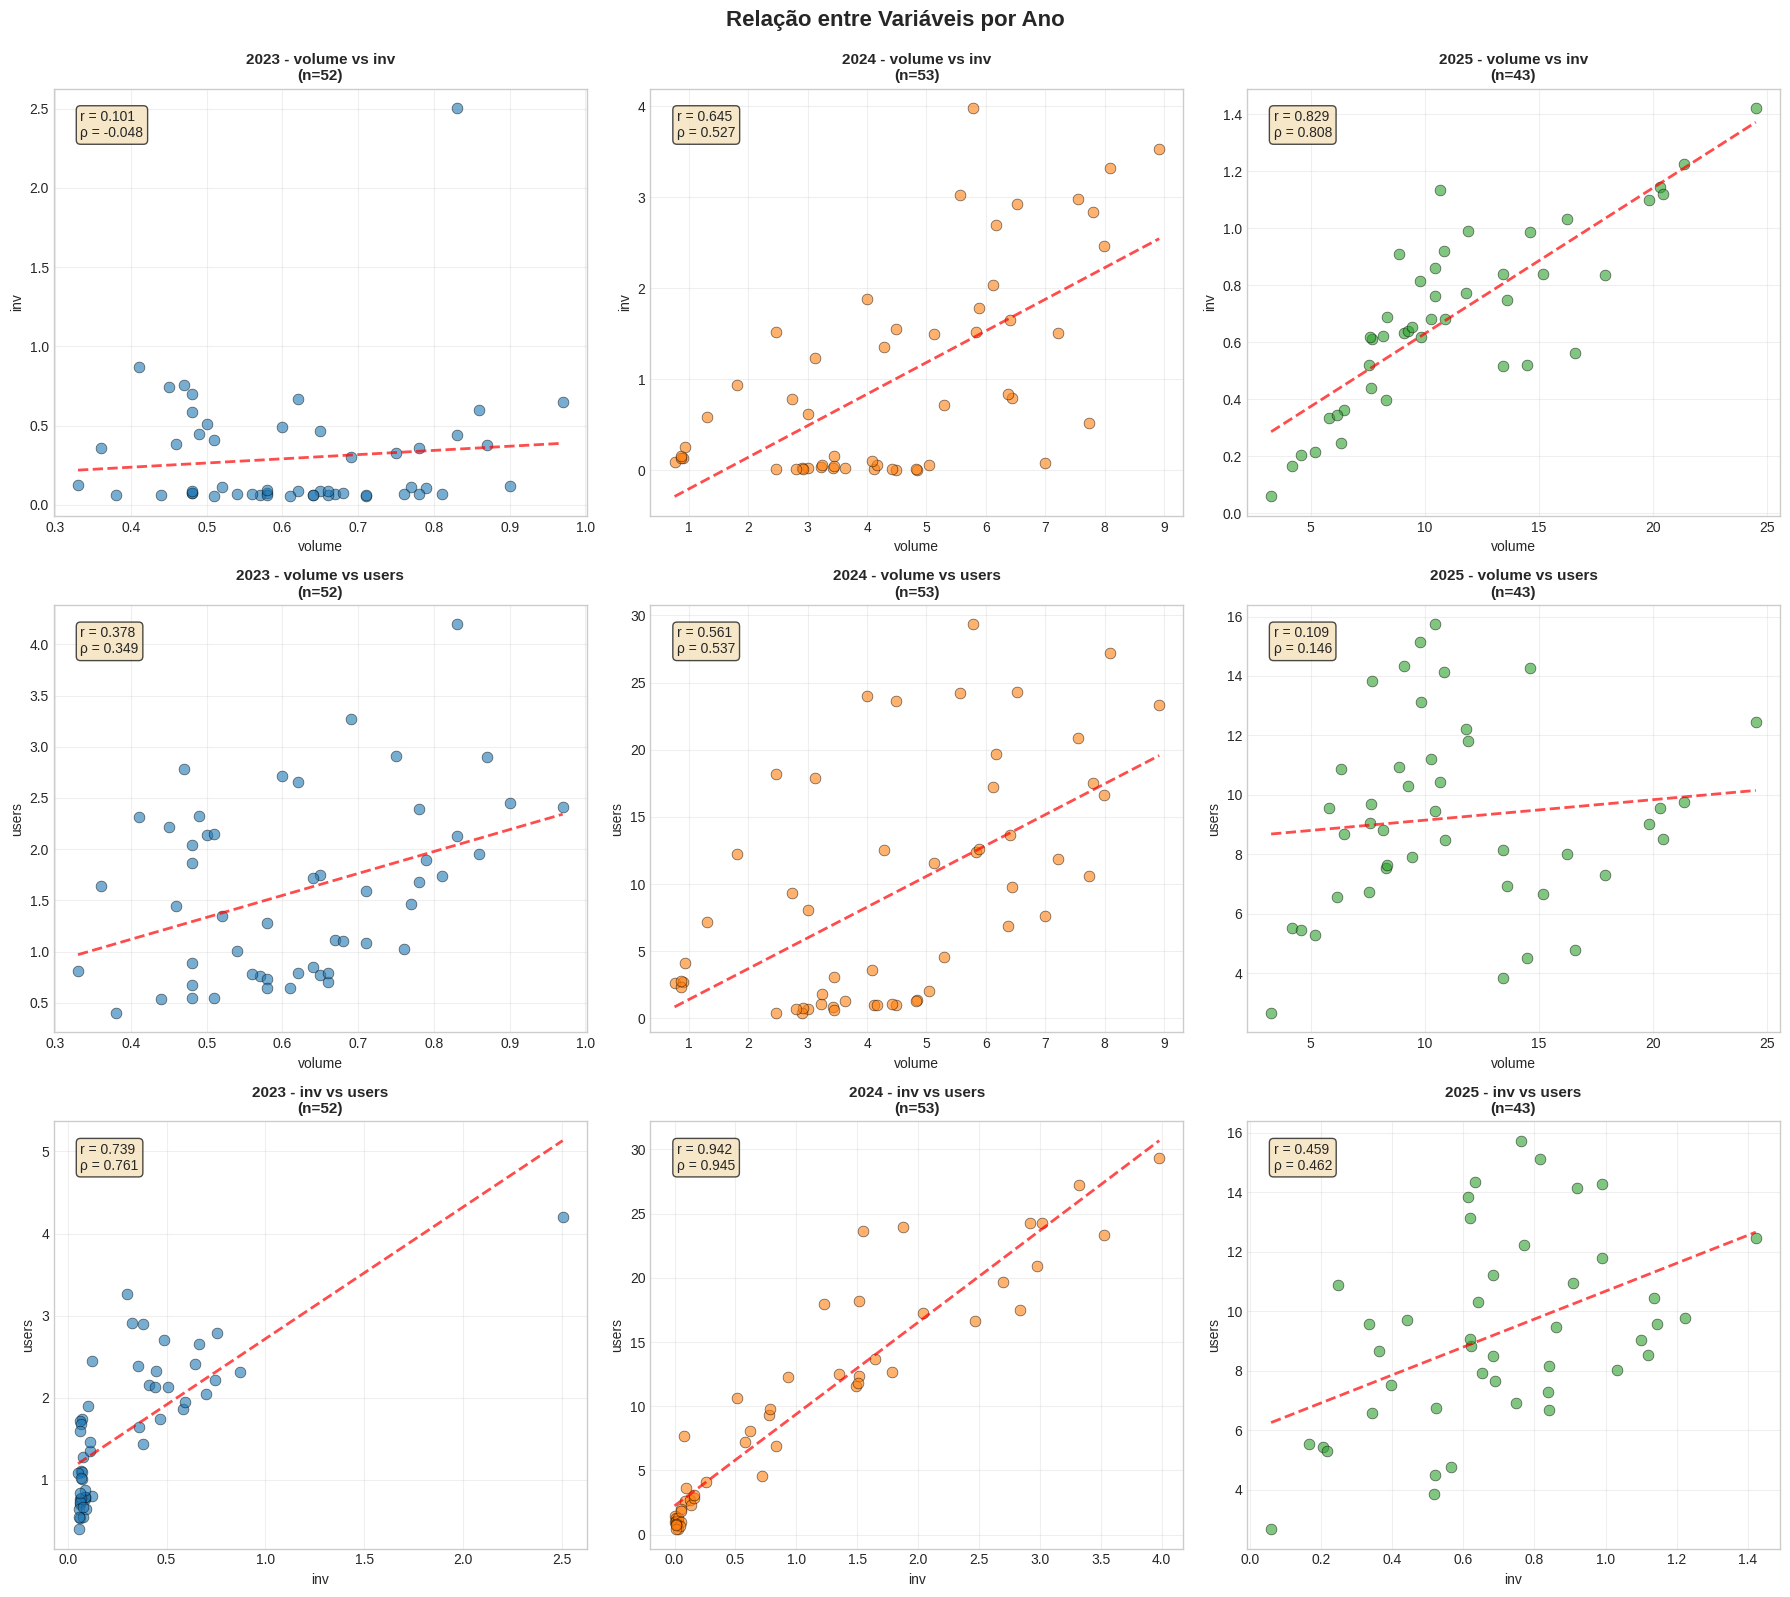

In [51]:
# Scatter plots por ano para visualizar a relação
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

year_colors = {'2023': '#1f77b4', '2024': '#ff7f0e', '2025': '#2ca02c'}

for i, (pair, pair_name) in enumerate(zip(pairs, pair_names)):
    var1, var2 = pair

    for j, (year, year_data) in enumerate([('2023', data_2023), ('2024', data_2024), ('2025', data_2025)]):
        ax = axes[i, j]

        # Scatter plot
        ax.scatter(year_data[var1], year_data[var2],
                  alpha=0.6, s=60, color=year_colors[year],
                  edgecolors='black', linewidth=0.5)

        # Linha de tendência
        if len(year_data) > 2:
            z = np.polyfit(year_data[var1], year_data[var2], 1)
            p = np.poly1d(z)
            x_line = np.linspace(year_data[var1].min(), year_data[var1].max(), 100)
            ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.7)

        # Correlação
        corr_p = year_data[var1].corr(year_data[var2])
        corr_s = year_data[var1].corr(year_data[var2], method='spearman')

        ax.text(0.05, 0.95, f'r = {corr_p:.3f}\nρ = {corr_s:.3f}',
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

        ax.set_xlabel(var1, fontsize=10)
        ax.set_ylabel(var2, fontsize=10)
        ax.set_title(f'{year} - {pair_name}\n(n={len(year_data)})', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.suptitle('Relação entre Variáveis por Ano', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


Bom, agora parece que há um relação extremamente linear entre 'inv' e 'user' em 2024. Enquanto em 2025 parece praticamente não haver.

Já 'volume' e 'user' não apresentam nenhum padrão significativo.

Enquanto 'volume' e 'inv' parecem ter um grande grau de relação em 2023 e 2025.